In [13]:
# Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle as pkl
from matplotlib.ticker import (LogLocator)
from IPython.display import HTML
import os
mpl.rcParams.update({'font.size': 14})

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "data"))
OUTPUTS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "outputs"))

In [39]:
filename = 'test'
size = 1024

# Load PINN outputs
with open(OUTPUTS_PATH + '/pinn_loss_' + filename + '.pkl', 'rb') as file:
    pinn_loss = pkl.load(file)
    
with open(OUTPUTS_PATH + '/boundary_loss_' + filename + '.pkl', 'rb') as file:
    boundary_loss = pkl.load(file)
    
with open(OUTPUTS_PATH + '/predictions_' + filename + '.pkl', 'rb') as file:
    predictions = pkl.load(file)
    
with open(DATA_PATH + '/f_boundary_' + str(size) + '.pkl', 'rb') as file:
    f_boundary = pkl.load(file)

with open(DATA_PATH + '/p_' + str(size) + '.pkl', 'rb') as file:
    p = pkl.load(file)

with open(DATA_PATH + '/T_' + str(size) + '.pkl', 'rb') as file:
    T = pkl.load(file)

with open(DATA_PATH + '/r_' + str(size) + '.pkl', 'rb') as file:
    r = pkl.load(file)

with open(DATA_PATH + '/J_' + str(size) + '.pkl', 'rb') as file:
    J = pkl.load(file)

In [40]:
# If many epochs, can only exponentiate some of the predictions
# predictions = predictions[:, :, -100:]

# Scale prediction and f_boundary back to real space
f_bound = np.array([-34.54346331847909, 6.466899920699378], dtype='float32')
f_boundary = np.exp((f_boundary*np.abs(f_bound[1]-f_bound[0])) + f_bound[0])
predictions = np.exp((predictions*np.abs(f_bound[1]-f_bound[0])) + f_bound[0])

# Get properties
size = int(np.sqrt(predictions.shape[0]))
epochs = int(predictions.shape[2])

# Check data
print(f'F_boundary shape: {f_boundary.shape}, min: {np.min(f_boundary)}, max: {np.max(f_boundary)}')
print(f'Predictions shape: {predictions.shape}, min: {np.min(predictions[:, :, -1].reshape((size, size))[-1, :-1])}, max: {np.max(predictions[:, :, -1].reshape((size, size))[-1, :-1])}')
print("Mean absolute difference in final epoch: ", np.mean(np.abs(predictions[:, :, -1].reshape((size, size))[-1, :] - f_boundary[:, 0])))

F_boundary shape: (1024, 1), min: 9.953227070295088e-16, max: 643.4857432802897
Predictions shape: (1048576, 1, 50), min: 2.4701693271264356e-14, max: 31.511374859347587
Mean absolute difference in final epoch:  39.072002494173304


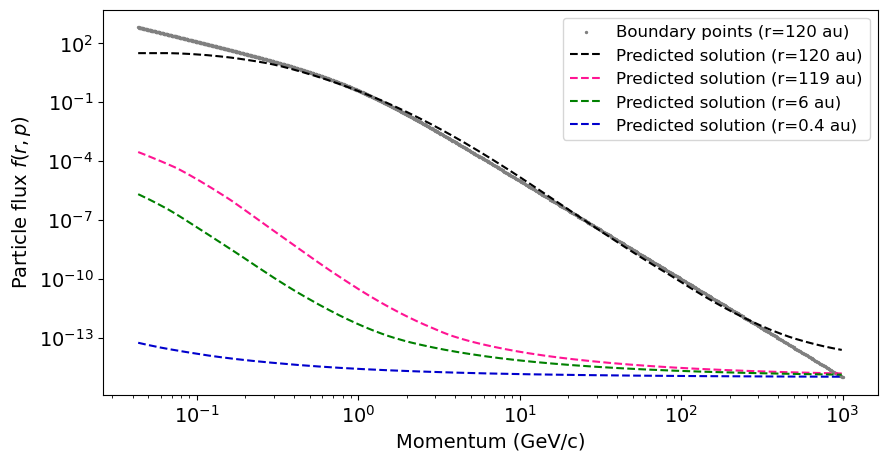

In [41]:
# Plot f(r, p)
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(p, f_boundary, label=f'Boundary points (r={r[-1, 0]/150e6:.0f} au)', s=2, c='gray')
ax.loglog(p[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[-1, :-1], axis=1), label=f'Predicted solution (r={r[-1, 0]/150e6:.0f} au)', ls='--', c='black')
ax.loglog(p[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[500, :-1], axis=1), label=f'Predicted solution (r={r[-2, 0]/150e6:.0f} au)', ls='--', c='deeppink')
ax.loglog(p[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[400, :-1], axis=1), label=f'Predicted solution (r={r[500, 0]/150e6:.0f} au)', ls='--', c='green')
ax.loglog(p[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[0, :-1], axis=1), label=f'Predicted solution (r={r[0, 0]/150e6:.1f} au)', ls='--', c='mediumblue')

ax.set_xlabel("Momentum (GeV/c)")
ax.set_ylabel("Particle flux $f(r, p)$")
ax.legend(prop={'size': 12})

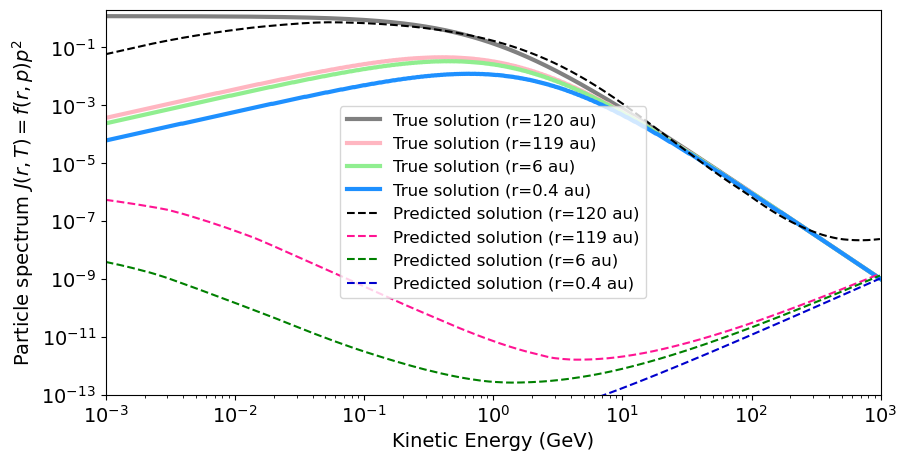

In [42]:
# Plot J(r, T)
fig, ax = plt.subplots(figsize=(10, 5))

ax.loglog(T, J[-1, :], label=f'True solution (r={r[-1, 0]/150e6:.0f} au)', lw='3', c='gray')
ax.loglog(T, J[500, :], label=f'True solution (r={r[-2, 0]/150e6:.0f} au)', lw='3', c='lightpink')
ax.loglog(T, J[400, :], label=f'True solution (r={r[500, 0]/150e6:.0f} au)', lw='3', c='lightgreen')
ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6:.1f} au)', lw='3', c='dodgerblue')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[-1, 0]/150e6:.0f} au)', ls='--', c='black')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[500, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[-2, 0]/150e6:.0f} au)', ls='--', c='deeppink')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[400, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[500, 0]/150e6:.0f} au)', ls='--', c='green')
ax.loglog(T[:-1], np.expand_dims(predictions[:, :, -1].reshape((size, size))[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6:.1f} au)', ls='--', c='mediumblue')

ax.set_xlabel("Kinetic Energy (GeV)")
ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(1e-13, 2e0)
ax.legend(prop={'size': 12})

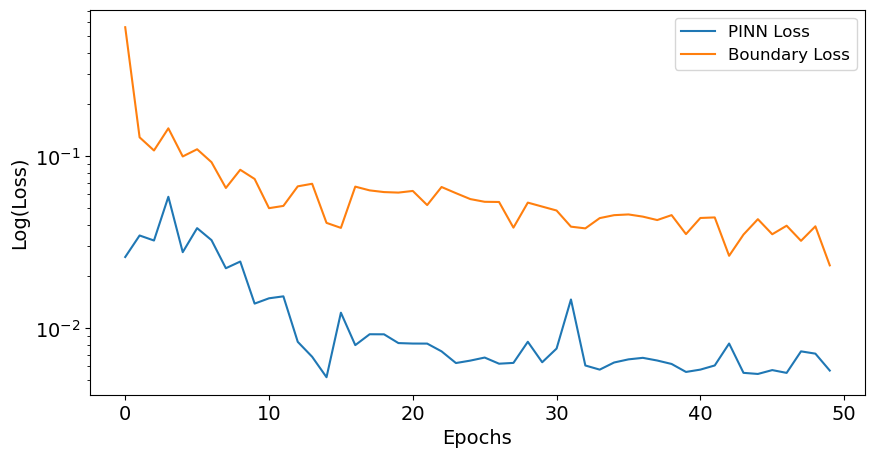

In [44]:
# Plot loss 
fig = plt.figure(figsize=(10, 5))

plt.plot(pinn_loss, label='PINN Loss')
plt.plot(boundary_loss, label='Boundary Loss')

plt.yscale('log')
# plt.ylim(1e-5, 1e-1)
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.legend(prop={'size': 12})

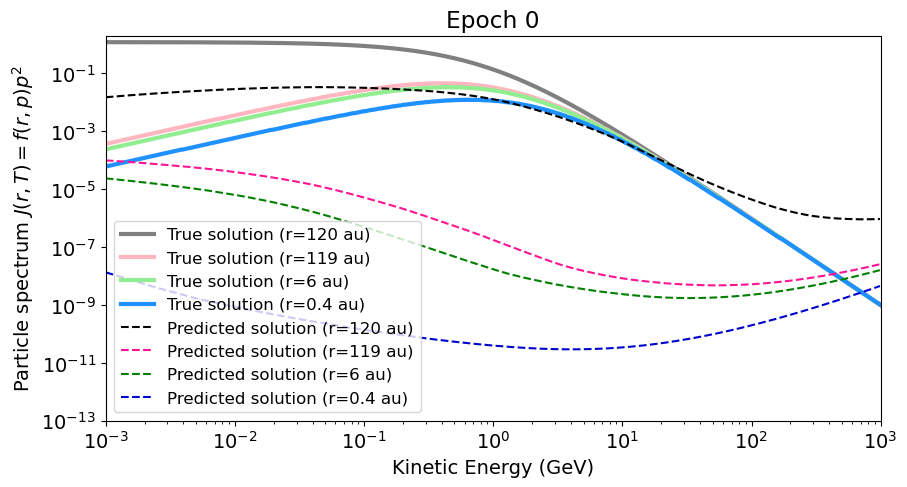

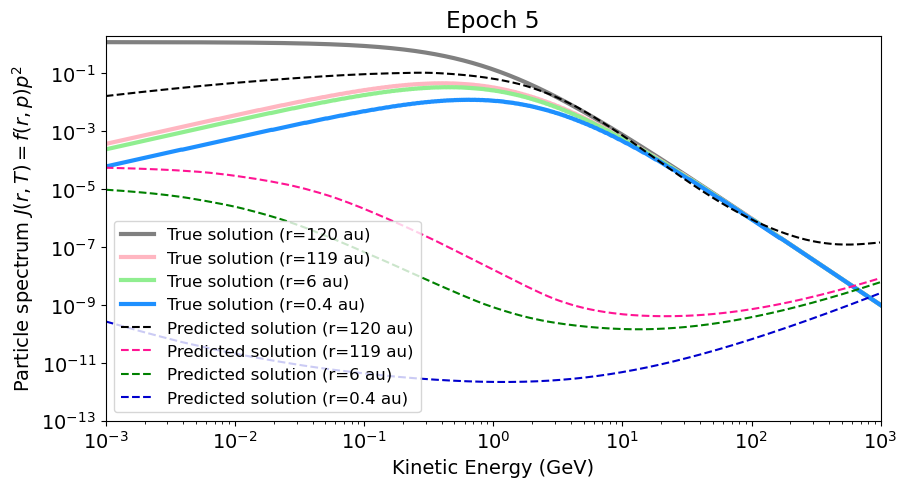

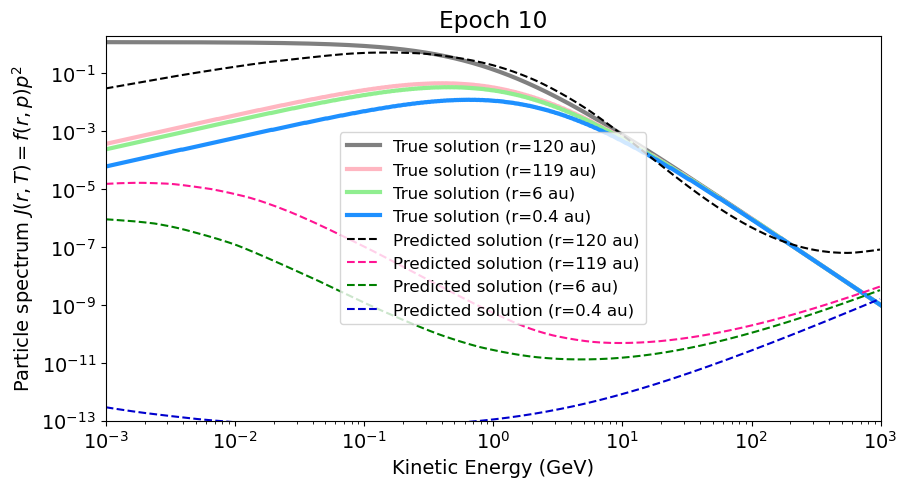

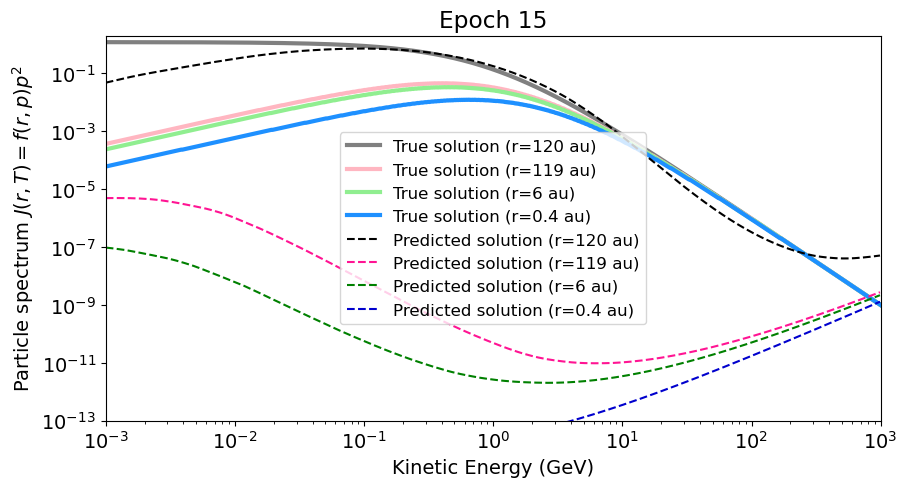

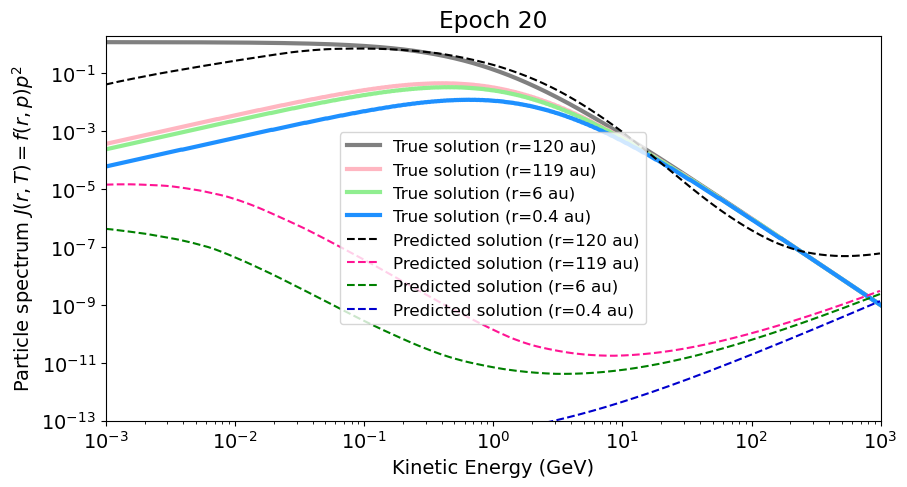

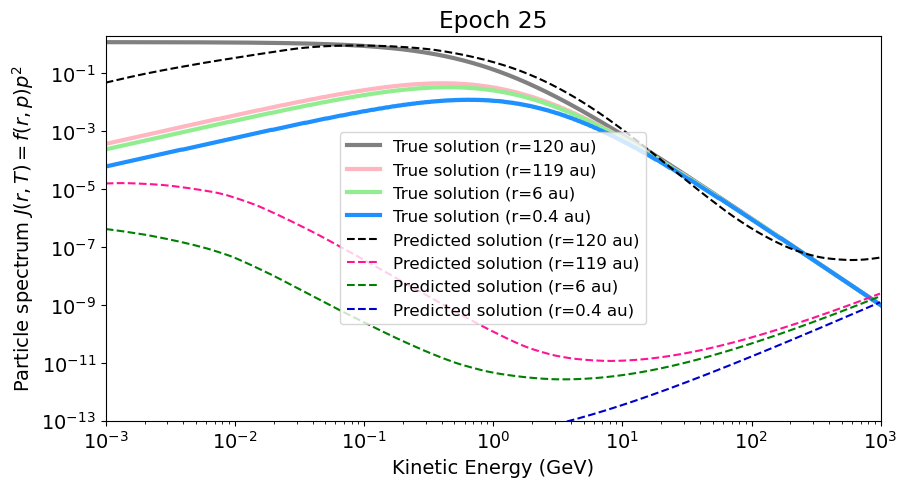

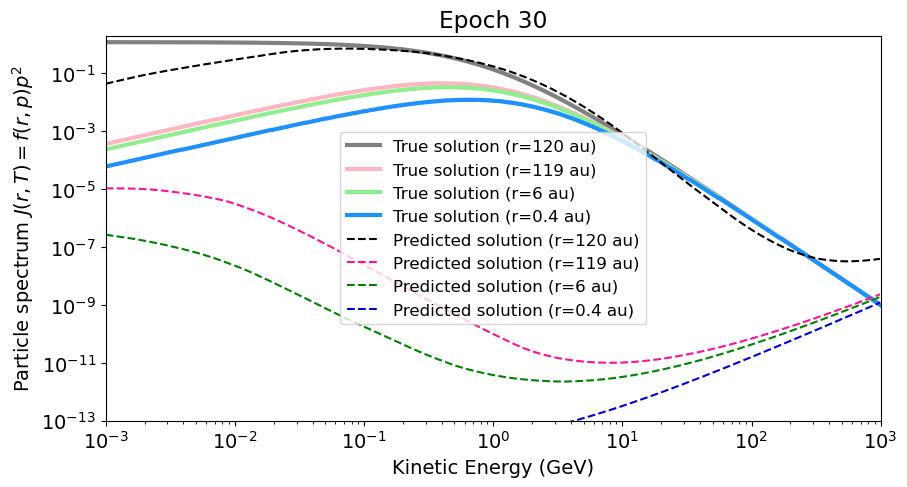

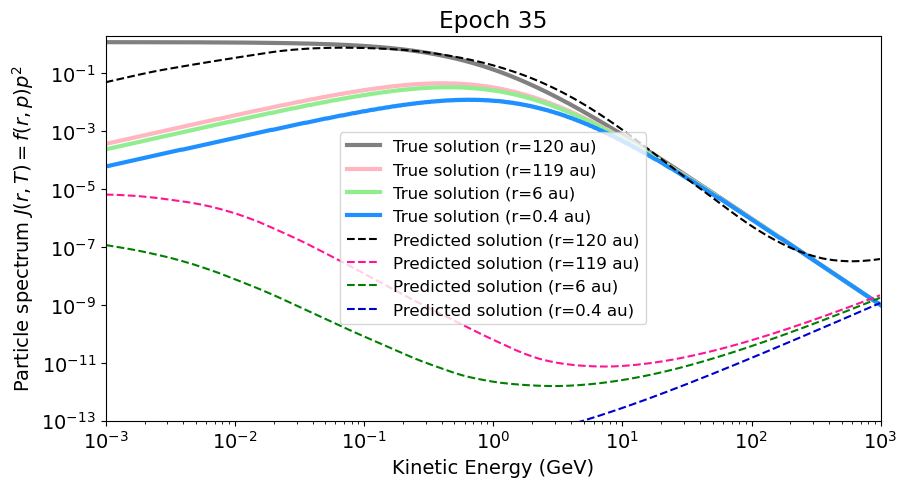

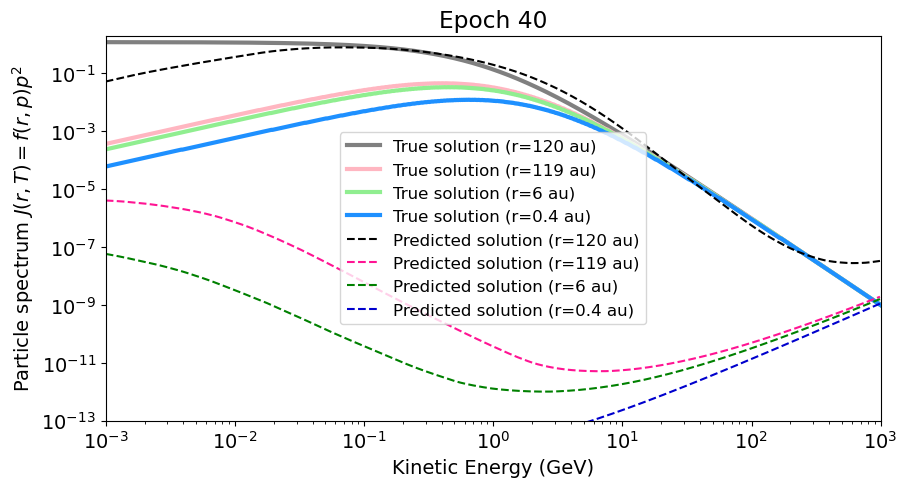

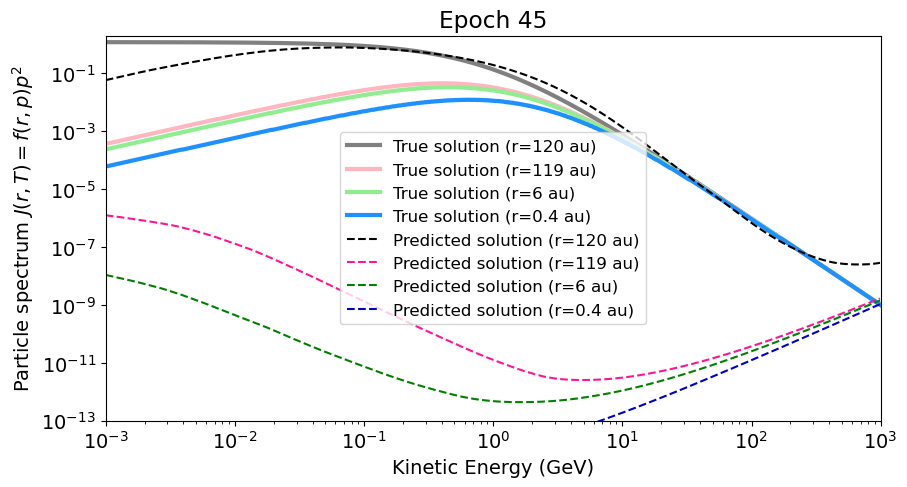

In [45]:
# Visualize J(r, T) over the epochs
for i in range(epochs):
    if (i%(epochs/10) == 0):
        fig, ax = plt.subplots(figsize=(10, 5))
        
        ax.set_title("Epoch " + str(i))
        ax.set_xlabel("Kinetic Energy (GeV)")
        ax.set_ylabel("Particle spectrum $J(r, T) = f(r, p) p^2$")
        ax.set_xlim(1e-3, 1e3)
        ax.set_ylim(1e-13, 2e0)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))
    
        ax.loglog(T, J[-1, :], label=f'True solution (r={r[-1, 0]/150e6:.0f} au)', lw='3', c='gray')
        ax.loglog(T, J[500, :], label=f'True solution (r={r[-2, 0]/150e6:.0f} au)', lw='3', c='lightpink')
        ax.loglog(T, J[400, :], label=f'True solution (r={r[500, 0]/150e6:.0f} au)', lw='3', c='lightgreen')
        ax.loglog(T, J[0, :], label=f'True solution (r={r[0, 0]/150e6:.1f} au)', lw='3', c='dodgerblue')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[-1, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[-1, 0]/150e6:.0f} au)', ls='--', c='black')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[500, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[-2, 0]/150e6:.0f} au)', ls='--', c='deeppink')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[400, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[500, 0]/150e6:.0f} au)', ls='--', c='green')
        ax.loglog(T[:-1], np.expand_dims(predictions[:, :, i].reshape((size, size))[0, :-1], axis=1)*(p[:-1]**2), label=f'Predicted solution (r={r[0, 0]/150e6:.1f} au)', ls='--', c='mediumblue')

        ax.legend(prop={'size': 12})